# Urban Cycling Dynamics: A Comprehensive Analysis of Bike Counts in Germany — Part 2

## Holt-Winters Munich

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
from datetime import datetime

## Matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter, MultipleLocator
from matplotlib.pylab import rcParams

## Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


RANDOM_SEED = np.random.seed(0)
rcParams['figure.figsize'] = 10, 6

muc_2015 = "./munich2015.csv"
muc_2016 = "./munich2016.csv"
muc_2017 = "./munich2017.csv"
muc_2018 = "./munich2018.csv"
muc_2019 = "./munich2019.csv"
muc_2020 = "./munich2020.csv"
muc_2021 = "./munich2021.csv"
muc_2022 = "./munich2022.csv"

df_muc_2015 = pd.read_csv(muc_2015)
df_muc_2016 = pd.read_csv(muc_2016)
df_muc_2017 = pd.read_csv(muc_2017)
df_muc_2018 = pd.read_csv(muc_2018)
df_muc_2019 = pd.read_csv(muc_2019)
df_muc_2020 = pd.read_csv(muc_2020)
df_muc_2021 = pd.read_csv(muc_2021)
df_muc_2022 = pd.read_csv(muc_2022)

df_munich = pd.concat([df_muc_2015,df_muc_2016,df_muc_2017,df_muc_2018,df_muc_2019,df_muc_2020,df_muc_2021,df_muc_2022], ignore_index=True)

# Since all the values of the column Uhrzeit start and end are always the same, they are not really needed for the analysis, we then will drop these columns
# List of columns to drop
columns_to_drop = ['uhrzeit_start', 'uhrzeit_ende', 'kommentar', 'richtung_1', 'richtung_2', 'bewoelkung', 'sonnenstunden']

df_munich = df_munich.rename(columns={
    'datum':'Date',
    'zaehlstelle': 'Location',
    'gesamt':'Total',
    'min.temp':'MinTemp',
    'max.temp':'MaxTemp',
    'niederschlag':'RainfallVolume'})

# Drop the specified columns
df_munich = df_munich.drop(columns=columns_to_drop)
df_munich = df_munich.sort_values(by='Date')

df_munich['Date'] = pd.to_datetime(df_munich['Date'])
# Calculate average temperature
df_munich['AvgTemp'] = (df_munich['MinTemp'] + df_munich['MaxTemp']) / 2
# Get list of unique locations names
unique_locations = df_munich['Location'].unique()
print(unique_locations)
df_munich.info()

['Arnulf' 'Olympia' 'Hirsch' 'Kreuther' 'Margareten' 'Erhardt']
<class 'pandas.core.frame.DataFrame'>
Index: 17501 entries, 0 to 17500
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            17501 non-null  datetime64[ns]
 1   Location        17501 non-null  object        
 2   Total           17051 non-null  float64       
 3   MinTemp         17501 non-null  float64       
 4   MaxTemp         17501 non-null  float64       
 5   RainfallVolume  17501 non-null  float64       
 6   AvgTemp         17501 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 1.1+ MB


In [31]:
df_location_erhardt = df_munich[df_munich['Location']=='Erhardt'].reset_index()
df_location_erhardt.to_csv('Erhardt_Years.csv', index = True)
df_location_erhardt = df_location_erhardt[['Date','Total']]

df_location_erhardt['Date'] = pd.to_datetime(df_location_erhardt['Date'])

df_m_e_model = df_location_erhardt.set_index(['Date'])

df_m_e_model.index.freq = 'D'

In [23]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_m_e_model['Total'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

from statsmodels.tsa.stattools import kpss

# Perform KPSS test
result = kpss(df_m_e_model)

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

Results of Dickey Fuller Test:


Test Statistic                   -3.669835
p-value                           0.004558
#Lags Used                       28.000000
Number of Observations Used    2893.000000
Critical Value (1%)              -3.432612
Critical Value (5%)              -2.862540
Critical Value (10%)             -2.567302
dtype: float64
Test Statistic: 1.113281649902229
P-value: 0.01


/var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/ipykernel_46713/3326370206.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df_m_e_model)


## Notes:
The Augmented Dickey-Fuller (ADF) test result suggests that the time series is  **stationary**, as indicated by a p-value less than 0.05, which means that we likely don't need to difference the data to make it stationary. However, the KPSS test result suggests the presence of a trend in your series, which is something to keep in mind as we model.

## Next Steps in Modeling
### Seasonality and Trend Decomposition: 
Before diving into modeling, it might be helpful to decompose the time series into trend, seasonal, and residual components using seasonal_decompose. <br> 
This can give insights into the nature of the underlying patterns in the data, such as regular seasonal effects or long-term trends, which can influence the choice of model.<br><br><br>
The seasonal decomposition output you've provided gives you a breakdown of the components within your time series data. Each subplot represents a different component that, when combined, reconstruct your original time series data. Let's go through each one:

### Top Subplot: Original Bike Counts
- This is your raw data. It shows the number of bike counts over time. You can see the overall patterns, trends, and cycles in the data. For instance, there might be periodic peaks and troughs corresponding to specific times of the year, such as warmer or colder months when people are more or less likely to cycle.

### Second Subplot: Trend
- The trend component represents the long-term progression of your time series data. It's the smooth, slowly varying aspect of the series. The trend shows changes in the data that aren't tied to seasonality or irregular fluctuations. In your plot, the trend captures the upward or downward movements over several years. This might be due to increasing or decreasing popularity of biking, changes in population, or other long-term factors affecting bike usage.

### Third Subplot: Seasonality
- The seasonality component captures the regular pattern that occurs at fixed periods, such as daily, weekly, monthly, or yearly. This is the cyclical effect that is seen consistently over time. In your plot, this would represent the cycling patterns that repeat in a consistent way over the given period. It looks like a constant series because the seasonal effect is consistent and is being repeated for each cycle. This could represent more people biking in warmer months and fewer in colder months, assuming the data has a yearly cycle.

### Bottom Subplot: Residuals
- The residuals, or sometimes called "irregular" or "remainder", represent the random variation in the data after the trend and seasonality have been removed. These are fluctuations that cannot be attributed to the trend or seasonal components. They might be due to random, unpredictable events or might be noise. Ideally, you want your residuals to look like "white noise"—a series of random fluctuations that don't show any pattern.

### Interpretation Tips for Thesis Writing:
1. **Contextualize Your Components**: When writing your thesis, make sure you explain these components in the context of the real-world phenomena they might represent. For example, if bike counts increase over the years, consider what might cause this trend—is there a city policy promoting biking, or has there been an increase in bike lanes?

2. **Seasonality**: For the seasonality component, try to match the observed pattern with known seasonal events, such as weather changes, holidays, or city events that could affect bike usage. It's essential to explain why the seasonality might

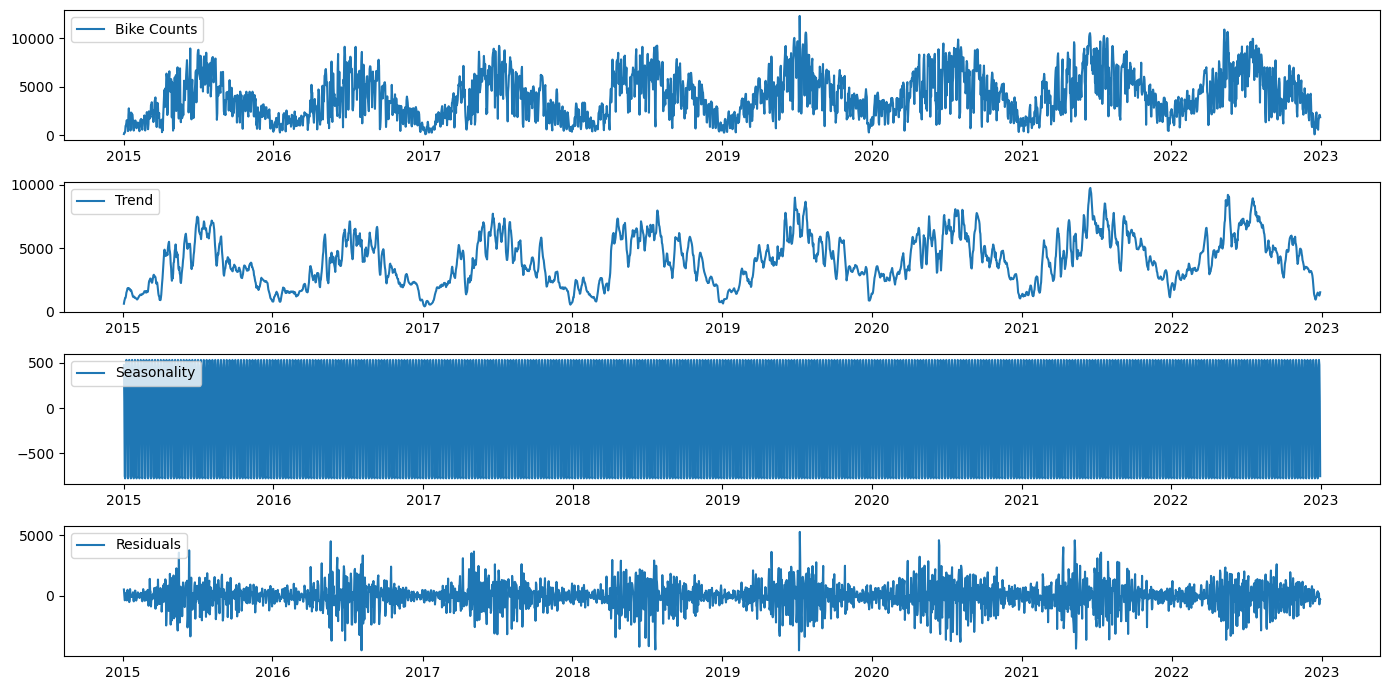

In [26]:
decomposition = seasonal_decompose(df_m_e_model['Total'], model='additive') # Use an additive model when the seasonal variations are roughly constant through the series

# Assign the trend, seasonal, and residual components to separate variables
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
plt.figure(figsize=(14,7))

plt.subplot(411)
plt.plot(df_m_e_model['Total'], label='Bike Counts')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()

These ACF and PACF plots are useful for determining the parameters of an ARIMA(p,d,q) model.

### Autocorrelation Function (ACF) plot
It shows the correlation of the series with its own lags. In this plot, we see a gradual decline in the autocorrelations as the number of lags increases, which suggests that there is a significant amount of autocorrelation present. The autocorrelations are still within the confidence interval for many lags, but slowly decreasing.

### Partial Autocorrelation Function (PACF) plot 
This shows the partial correlation of a series with its own lagged values, controlling for the values of the time series at all shorter lags. The PACF cuts off after the first lag in our plot, which suggests an AR(1) component might be appropriate. This is because after the first lag, the partial autocorrelations are essentially zero, indicating no additional correlation beyond the first lag. <br><br>
When using the PACF to help build an AR model, we’re looking for where the PACF plot cuts off because that suggests the number of past values which significantly affect the current value. If the PACF plot shows a sharp drop after lag 1 and the rest of the lags are not significant, this implies an AR(1) model could be appropriate. It means that only the first lag has a significant partial correlation with the current value after accounting for the correlations at all shorter lags.

#### The Role of PACF in Model Selection
Why is this useful? In ARIMA modeling, we need to know how many AR terms to include. The PACF plot can help us determine this. If we see a sharp cut-off in the PACF at lag 1, and the rest of the lags are within the blue shaded area (which represents a confidence interval for the statistical significance), then we would consider starting with an AR(1) model. If the cut-off were at lag 2, we might start with an AR(2), and so on.

### What the Plots Suggest for Model Parameters:

For an **ARIMA model**, the p parameter can be initially chosen based on where the PACF cuts off (after lag 1 in our case). This would suggest a potential ARIMA(p,d,q) model with p=1. <br><br>
The d parameter is the degree of differencing required to make the series stationary. Since our ADF test suggested the series was stationary, we may not need any differencing (d=0), but we should verify this by looking at the data and considering the KPSS test result, which suggested a trend.<br><br>
The q parameter can be chosen based on where the ACF plot tails off. However, in our plot, the ACF does not sharply cut off, which makes it more difficult to choose the q value. It slowly decreases, which might indicate a Moving Average (MA) component is less clear, and we might start with q=0 or q=1 and experiment from there.

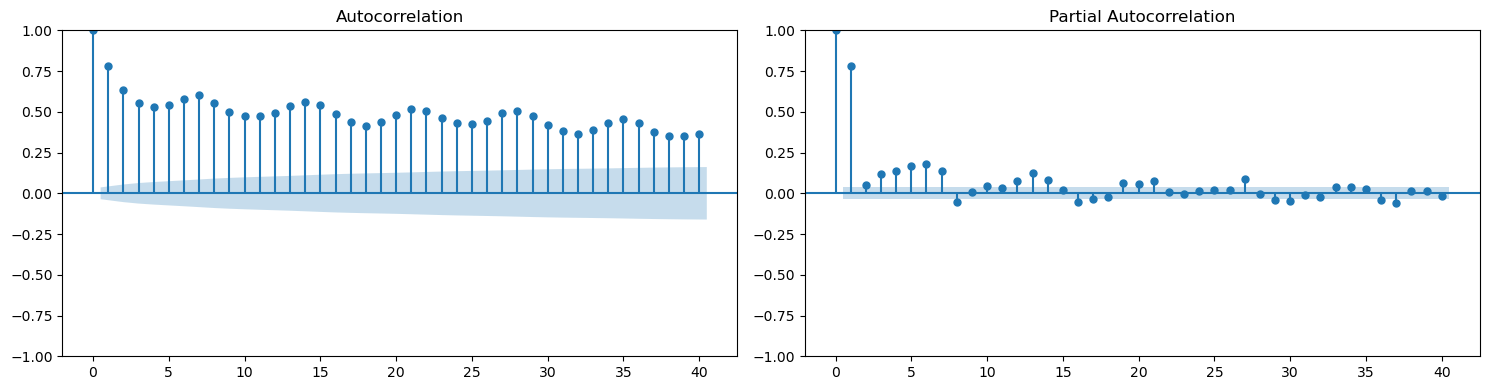

In [27]:
# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Plot the Autocorrelation Function (ACF)
plot_acf(df_m_e_model['Total'], lags=40, ax=axes[0])

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(df_m_e_model['Total'], lags=40, ax=axes[1])

plt.tight_layout()
plt.show()

## ARIMA model 

**The ARIMA model** has three parameters (p, d, q):

p is the number of autoregressive terms (AR).
d is the number of nonseasonal differences needed for stationarity.
q is the number of lagged forecast errors in the prediction equation (MA or moving average terms).
The PACF helps with determining the 'p' part of the ARIMA model. If the PACF indicates an AR(1) model, then p would be set to 1 when specifying your ARIMA model.

In [37]:

# Make sure your data does not contain any NaN values, as the ARIMA model cannot handle them.
df_m_e_model = df_m_e_model.dropna()

# Start with the parameters (p=1, d=0, q=0) based on the PACF plot.
arima_model = ARIMA(df_m_e_model['Total'], order=(2, 0, 2))

# Fit the model
arima_result = arima_model.fit()

# Print out the summary of the fit
print(arima_result.summary())


/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                 2922
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -25209.256
Date:                Fri, 15 Mar 2024   AIC                          50430.512
Time:                        21:02:11   BIC                          50466.392
Sample:                    01-01-2015   HQIC                         50443.435
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4045.8411    542.186      7.462      0.000    2983.176    5108.506
ar.L1          1.3538      0.036     37.496      0.000       1.283       1.425
ar.L2         -0.3595      0.035    -10.217      0.0

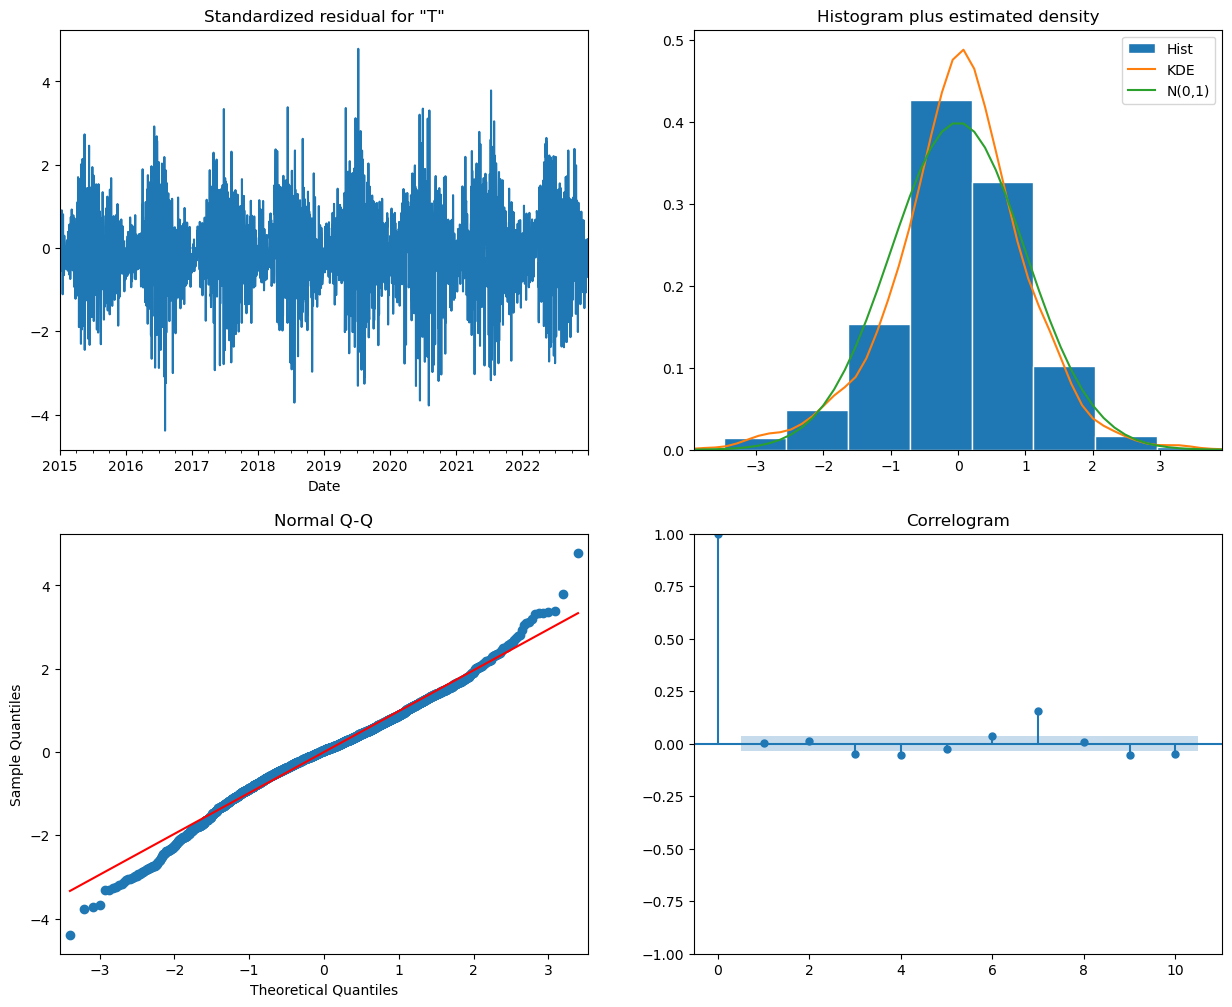

In [38]:
arima_result.plot_diagnostics(figsize=(15, 12))
plt.show()

## SARIMA
To extend the ARIMA model to a Seasonal ARIMA (SARIMA) model, you will incorporate seasonal elements into the model. SARIMA is denoted as SARIMA(p,d,q)(P,D,Q)s, where:

- p,d,q are the non-seasonal parameters that describe the autoregressive, differencing, and moving average parts of the ARIMA model.
- P,D,Q are the seasonal parts of the same that describe the seasonal autoregressive, differencing, and moving average parts of the SARIMA model.
- s is the periodicity of the time series (e.g., if the seasonality is yearly and data is collected monthly, s=12).

<br> First, identify if there is a seasonality component by looking at your data or the seasonal decomposition you performed earlier. Once you know the seasonality, you can start to build your SARIMA model.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.76809D+00    |proj g|=  6.59987D-02

At iterate    5    f=  8.73288D+00    |proj g|=  2.32057D-02

At iterate   10    f=  8.72637D+00    |proj g|=  1.41472D-03

At iterate   15    f=  8.72630D+00    |proj g|=  1.99133D-03

At iterate   20    f=  8.71189D+00    |proj g|=  1.09407D-01

At iterate   25    f=  8.65461D+00    |proj g|=  5.01956D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   

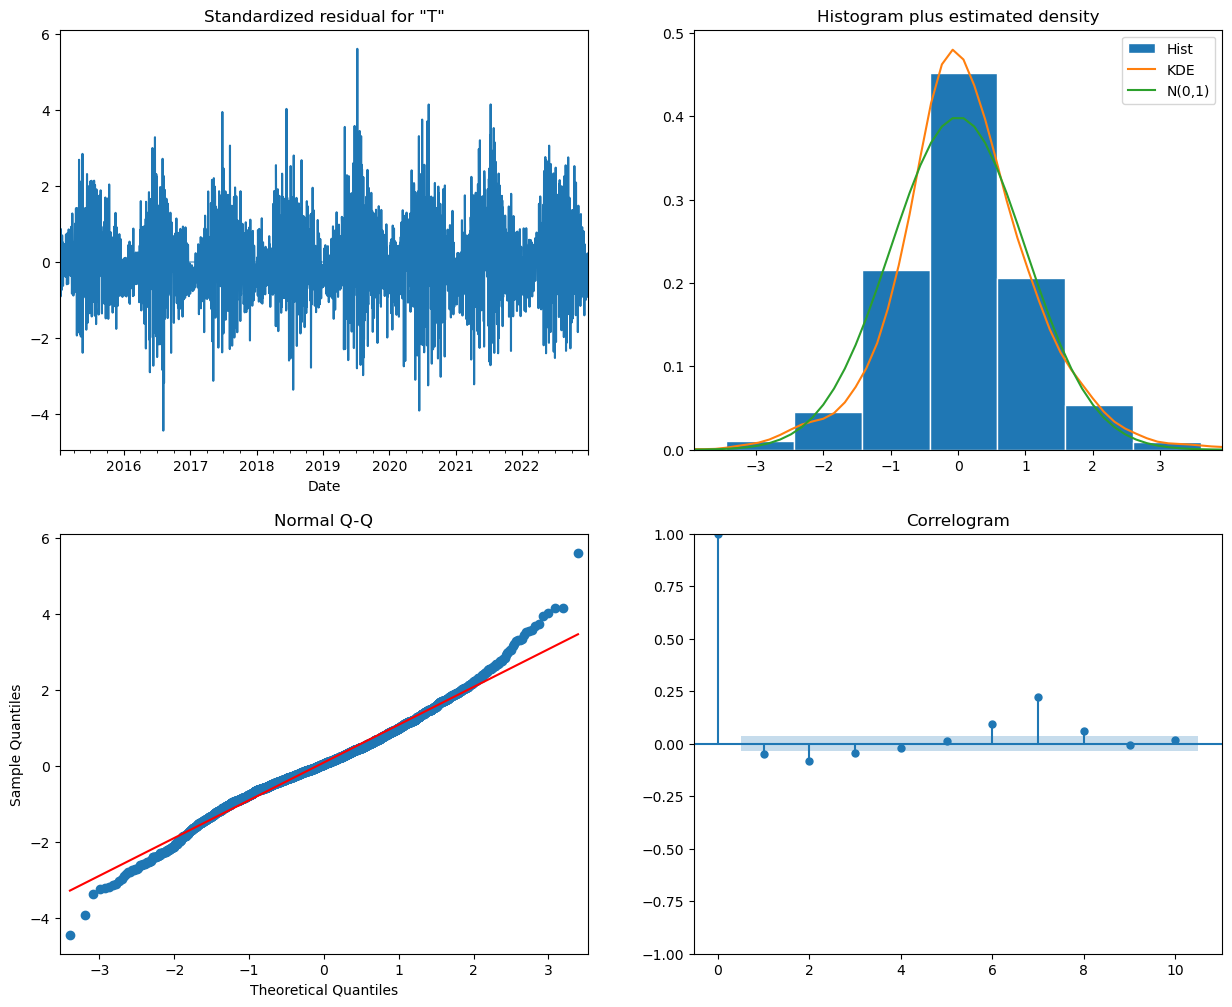

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model with some starting orders
sarima_model = SARIMAX(df_m_e_model['Total'], 
                       order=(1, 0, 0),              # non-seasonal (p, d, q) parameters
                       seasonal_order=(1, 1, 1, 12)) # the seasonal (P, D, Q, s) parameters

# Fit the model
sarima_result = sarima_model.fit()

# Summarize the model results
print(sarima_result.summary())

# Run model diagnostics
sarima_result.plot_diagnostics(figsize=(15, 12))
plt.show()